In [2]:
from d2l import torch as d2l
import os
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler



devices = d2l.try_all_gpus()

In [ ]:
def read_dataset(is_big_computer = False):
    names = ['user_id', 'movie_id', 'rating', 'timestamp']
    data = pd.read_csv("./ml-32m/ratings.csv", names=names, header=0)
    if not is_big_computer:
        data = data.sample(n=10_000, random_state=42) # Limit to 1 million ratings for faster processing
    else:
        data = data.sample(n=1_000_000, random_state=42) # Limit to 1 million ratings for faster processing

    data["user_id"] = data["user_id"]
    data["movie_id"] = data["movie_id"]
    num_users = data.user_id.unique().shape[0]
    num_movies = data.movie_id.unique().shape[0]
    return data, num_users, num_movies

def reindex_data(data : pd.DataFrame):
    user_id_map = {id: i for i, id in enumerate(data.user_id.unique())}
    movie_id_map = {id: i for i, id in enumerate(data.movie_id.unique())}
    
    data['user_id'] = data['user_id'].map(user_id_map)
    data['movie_id'] = data['movie_id'].map(movie_id_map)
    
    return data

In [ ]:
# data, num_users, num_movies = read_dataset()

In [ ]:
# sparsity = 1 - len(data) / (num_users * num_movies)
# print(f'number of users: {num_users}, number of movies: {num_movies}')
# print(f'matrix sparsity: {sparsity:f}')

number of users: 167266, number of movies: 27726
matrix sparsity: 0.999784


In [ ]:
# data[:5]

,user_id,movie_id,rating,timestamp
10685861,66954,781,5.0,850944577
1552723,9877,574,4.0,945495614
6145184,38348,1088,2.0,999974867
16268584,101952,2706,1.0,1203077565
22418634,140400,275079,3.5,1653782463


In [ ]:
# data.describe()

,user_id,movie_id,rating,timestamp
count,1000000.000000,1000000.000000,1000000.000000,1.000000e+06
mean,100339.282490,29349.124476,3.539737,1.275225e+09
std,57917.799297,51012.984959,1.059928,2.561240e+08
min,1.000000,1.000000,0.500000,8.231852e+08
25%,50154.750000,1230.000000,3.000000,1.051545e+09
50%,100311.000000,3452.000000,3.500000,1.272615e+09
75%,150499.000000,44199.000000,4.000000,1.503010e+09
max,200948.000000,292755.000000,5.000000,1.697164e+09


## Plot the distribution of the ratings

Text(0, 0.5, 'Count')

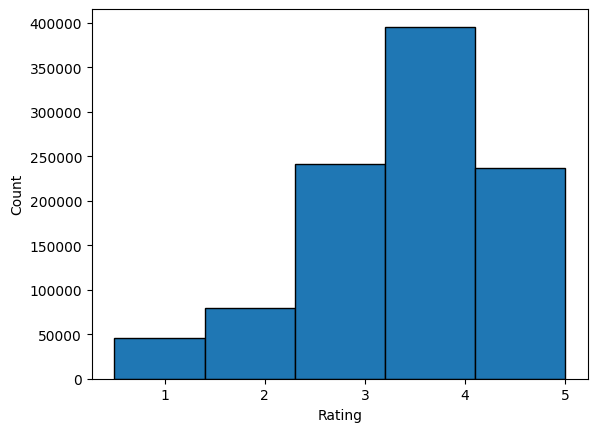

In [ ]:
# plt.hist(data["rating"], bins=5, edgecolor='black')
# plt.xlabel('Rating')
# plt.ylabel('Count')

## Splitting the dataset
We split the dataset into training and test sets. The following function provides two split modes including `random` and `seq-aware`. In the `random` mode, the function splits the 100k interactions randomly without considering timestamp and uses the 90% of the data as training samples and the rest 10% as test samples by default. In the `seq-aware` mode, we leave out the movie that a user rated most recently for test, and users’ historical interactions as training set. User historical interactions are sorted from oldest to newest based on timestamp. This mode will be used in the sequence-aware recommendation section.

In [4]:
def split_data(data : pd.DataFrame, num_users, num_movies, split_mode = "random", test_ratio=0.2):
    if split_mode == "random":
        training_mask = np.random.rand(len(data)) > test_ratio
        train_data = data[training_mask]
        test_data = data[~training_mask]
    
    elif split_mode == "seq-aware":
        user_groups = data.groupby('user_id')
        train_data = []
        test_data = []
        for _, group in user_groups:
            group = group.sort_values(by='timestamp', ascending=True)
            split_index = int(len(group) * (1 - test_ratio))
            train_data.append(group.iloc[:split_index])
            test_data.append(group.iloc[split_index:])
        train_data = pd.DataFrame(pd.concat(train_data, ignore_index=True))
        test_data = pd.DataFrame(pd.concat(test_data, ignore_index=True))
    
    else:
        raise ValueError("split_mode must be 'random' or 'seq-aware'")

    return train_data, test_data

## Loading the dataset

In [5]:
def load_data(data : pd.DataFrame, num_users, num_movies, feedback="explicit"):
    """
    returns lists of users, movies, ratings and a dictionary/matrix that records the interactions. 
    If feedback is "explicit", ratings are used as feedback.
    If feedback is "implicit", then the user didn't give any rating, so the user's action of interacting with the movie is considered as positive feedback.
    The `inter` is the interaction matrix that reflects this.
    """
    inter = np.zeros((num_movies, num_users)) if feedback == 'explicit' else {}

    if feedback == "explicit":
        scores = data["rating"].astype(int)
    else:
        scores = pd.Series(1, index=data.index)
    
    i = 0
    for line in data.itertuples(): # itertuples is faster than iterrows for large DataFrames
        user_id, movie_id = int(line.user_id), int(line.movie_id)
        if feedback == "explicit":
            inter[movie_id - 1, user_id - 1] = scores[i]
        else:
            inter.setdefault(user_id - 1, []).append(movie_id - 1)
        i += 1
        
    return list(data["user_id"]), list(data["movie_id"]), list(scores), inter


In [ ]:
def get_datasets(split_mode = "seq-aware", feedback="explicit", test_ratio = 0.1, is_big_computer = False):
    data, num_users, num_movies = read_dataset(is_big_computer)
    data = reindex_data(data)
    train_data, test_data = split_data(data, num_users, num_movies, split_mode=split_mode, test_ratio=test_ratio)

    train_users, train_movies, train_scores, train_inter = load_data(train_data, num_users, num_movies, feedback=feedback)
    test_users, test_movies, test_scores, test_inter = load_data(test_data, num_users, num_movies, feedback=feedback)

    train_u = torch.tensor(np.array(train_users))
    train_m = torch.tensor(np.array(train_movies))
    train_r = torch.tensor(np.array(train_scores), dtype=torch.float32)
    test_u = torch.tensor(np.array(test_users))
    test_m = torch.tensor(np.array(test_movies))
    test_r = torch.tensor(np.array(test_scores), dtype=torch.float32)

    train_set = torch.utils.data.TensorDataset(train_u, train_m, train_r)
    test_set = torch.utils.data.TensorDataset(test_u, test_m, test_r)

    return num_users, num_movies, train_set, test_set


def get_dataloaders(train_set : torch.utils.data.TensorDataset, test_set: torch.utils.data.TensorDataset, batch_size = 32):
    # Don't shuffle as we're using the Distributed Sampler here.
    # The trainer should call train_iter.sampler.set_epoch(epoch) at every epoch to shuffle.
    # Each process will receive batch_size samples per iteration.
    train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, sampler=DistributedSampler(train_set)) 
    test_iter = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, sampler=DistributedSampler(train_set))
    return train_iter, test_iter




In [ ]:
# num_users, num_movies, train_iter, test_iter = split_and_load_data(
#     test_ratio=0.1, batch_size=256)